### Setup

In [1]:
import numpy as np
from sklearn.datasets import make_regression
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.linear_model import ElasticNetCV, LinearRegression, Lars
from sklearn.svm import LinearSVR, SVR
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import cross_validate, train_test_split, RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
from vb_helper import VBHelper,shrinkBigKTransformer

In [2]:
from warnings import filterwarnings
filterwarnings('ignore')

DATA UPLOAD
- user uploads data
   - calculate n,k
   - calculate sparsity of y
   - calculate missing values of x by column
   - calcualte missing values of x by row
   - calculate n if rows with missing vals dropped
   - calculate rank of resulting matrix (k_drop_r)
   
- Train/test split






In [3]:
test_share=0.2 
cv_folds=10
cv_reps=30
cv_count=cv_folds*cv_reps
rs=1 # random_state for reproducibility
vbhelper=VBHelper(test_share,cv_folds,cv_reps,cv_count,rs)

##### Example Dataset

In [4]:
X, y, w = make_regression(n_samples=40,
                          n_features=30, # x variables generated and returned 
                          n_informative=12, # x variables included in the actual model of y
                          effective_rank=8, # make less than n_informative for multicollinearity
                          coef=True,
                          noise=3,
                          random_state=rs,
                          bias=0.5)
for i in range(0,30,2):
    sgn_mult=.03*i*(-1)**i
    y=y+sgn_mult*np.product(X[:,i:i+1],axis=-1) # some interaction effects
#y=y*np.sin(y)
#y=np.exp(y/100)

In [5]:
# add interaction terms

In [6]:
if test_share:
     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_share, random_state=rs)
else:
    X_train, X_test, y_train, y_test = (X, None, y, None)

In [7]:
n=X_train.shape[0]
max_k=n//4
vbhelper.max_k=max_k

## Model Selection
### define estimators
#### example:
 - make_pipeline(
   - handle missing values,
     - global: drop_rows or impute 
       - could also look for columns with many missing vals first
     - set cv_drop_rows variable if rows are dropped to make sure GBR doesn't use those in cross validation
   
   - make transformed columns,
   - Multi CV (make our own wrapper that chooses the best of model variations)
     - modify model (e.g., transform Y)
       - combined selection/estimation (e.g., lars(https://scikit-learn.org/stable/modules/linear_model.html#least-angle-regression))
       - pre-select-features -> CV estimate
         - for lin reg with k>n, 
           - select features k << n
           - project data such that k << n
   - set final model as best in the pipeline based on chosen loss (mse default for continuous y)
   
   

   


In [8]:
# use lambda to make a callable object for creating new models, but with args set already
linear_regression=lambda: make_pipeline(StandardScaler(),LinearRegression(fit_intercept=1)) # lambda so args,kwargs can be specified now rather than later
linear_regression_lars=lambda: make_pipeline(StandardScaler(),shrinkBigKTransformer(max_k=max_k),LinearRegression(fit_intercept=1)) #https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lars.html
elastic_net =lambda: make_pipeline(StandardScaler(), ElasticNetCV(fit_intercept=1))
linear_svr =lambda: make_pipeline(StandardScaler(),LinearSVR(random_state=rs,tol=1e-4,max_iter=5000,C=1))
rbf_svr=lambda: make_pipeline(StandardScaler(),SVR(kernel='rbf',tol=1e-4,max_iter=5000, C=1))
gradient_boosting_reg=lambda: make_pipeline(GradientBoostingRegressor())

g_pts=3 # grid points for gridsearchcv param_grid 
linear_svr = Pipeline(steps=[('scaler',StandardScaler()),('lin_svr',LinearSVR(random_state=0,tol=1e-4,max_iter=10000))])
lin_svr_param_grid={'lin_svr__C':np.logspace(-2,2,g_pts)}
linear_svr_cv=lambda: GridSearchCV(linear_svr,param_grid=lin_svr_param_grid)

rbf_svr=Pipeline(steps=[('scaler',StandardScaler()),('rbf_svr',SVR(kernel='rbf',tol=1e-4,max_iter=10000, cache_size=2*10**3))])
rbf_svr_param_grid={'rbf_svr__C':np.logspace(-2,2,g_pts),'rbf_svr__gamma':np.logspace(-1,0.5,g_pts)} 
rbf_svr_cv=lambda: GridSearchCV(rbf_svr,param_grid=rbf_svr_param_grid)


estimator_dict={'linear-regression':linear_regression,
                'linear-regression-lars':linear_regression_lars,
            'elastic-net':elastic_net, 
            'linear-svr-cv':linear_svr_cv, 
            'rbf-svr-cv':rbf_svr_cv, 
            'gradient-boosting-reg':gradient_boosting_reg}
vbhelper.estimator_dict=estimator_dict
model_dict={key:val() for key,val in estimator_dict.items()} # they will be models once .fit is called

In [9]:
scorer_list=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'] #cross_validate wants strings
cv=RepeatedKFold(n_splits=cv_folds, n_repeats=cv_reps, random_state=rs) # define separately to ensure same cv data used for each model
vbhelper.scorer_list=scorer_list
# allow/generate water quality thresholds for stratified kfold sub-sampling to ensure cross-validation folds have full range of water quality

In [10]:
cv_results={estimator_name:cross_validate(model, X_train, y_train, return_estimator=True, scoring=scorer_list, cv=cv)
            for estimator_name,model in model_dict.items()}
# replace with a loop in order to save the residuals for a graph?

### graphs and table to summarize results

In [11]:
cv_score_dict={}
cv_score_dict_means={}
for idx,(estimator_name,result) in enumerate(cv_results.items()):
    #cv_estimators=result['estimator']
    model_idx_scoredict={scorer:result[f'test_{scorer}'] for scorer in scorer_list}# fstring bc how cross_validate stores list of metrics
    cv_score_dict[estimator_name]=model_idx_scoredict 
    model_idx_mean_scores={scorer:np.mean(scores) for scorer,scores in model_idx_scoredict.items()}
    cv_score_dict_means[estimator_name]=model_idx_mean_scores

In [12]:
for scorer in scorer_list:
    print(f'scores for scorer: {scorer}:')
    for estimator_name in model_dict:
        print(f'    {estimator_name}:{cv_score_dict_means[estimator_name][scorer]}')

scores for scorer: neg_mean_squared_error:
    linear-regression:-151.20445878277792
    linear-regression-lars:-63.160831197598284
    elastic-net:-57.11490119713213
    linear-svr-cv:-139.27451171080284
    rbf-svr-cv:-430.6609380489575
    gradient-boosting-reg:-204.57948229738938
scores for scorer: neg_mean_absolute_error:
    linear-regression:-9.17995900301194
    linear-regression-lars:-5.701956869774024
    elastic-net:-5.929303560164377
    linear-svr-cv:-8.921572353502599
    rbf-svr-cv:-17.126510786444804
    gradient-boosting-reg:-11.436312072481057
scores for scorer: r2:
    linear-regression:-0.8784503473223818
    linear-regression-lars:0.360114278023373
    elastic-net:0.2430257006950051
    linear-svr-cv:-0.8443975642599632
    rbf-svr-cv:-3.5523648704722808
    gradient-boosting-reg:-2.560952499636979


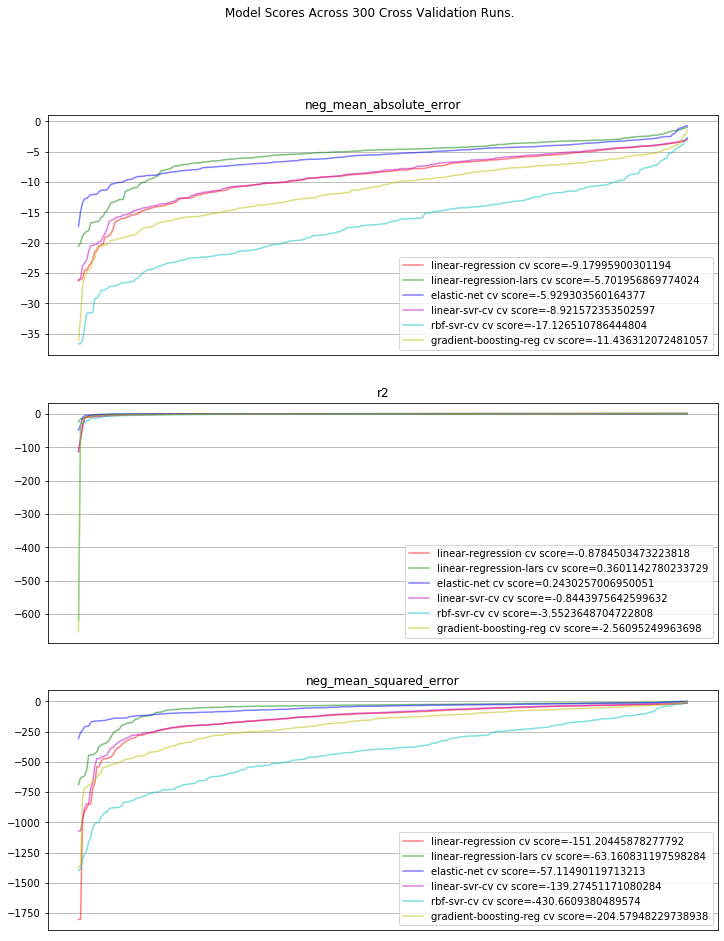

In [13]:
vbhelper.plotCVScores(cv_score_dict,sort=1)

In [14]:
# create a similar plot showing residuals from the cv models for each value of y. 
# needs to be scatterplot or histogram since there will be (folds-1)*repeats predictions of each value of y.

-----------------------------
### User chooses Linear Regression with LARS variable selection!


In [15]:
final_estimator_name='linear-regression-lars'

In [16]:
def printTestandCVScores(estimator_name,cv_score_dict_means):
    model=estimator_dict[estimator_name]()
    model.fit(X_train,y_train)
    if test_share:
        y_test_hat=model.predict(X_test)
        print(f'test set: negative-mse={-mean_squared_error(y_test,y_test_hat)}')
    for scorer in scorer_list:
        print(f'cv avg: {scorer}= {cv_score_dict_means[estimator_name][scorer]}')
    try:
        print('coefficients: ',model[-1].coef_)
        print('intercept: ',model[-1].intercept_)
        #print('\n','original positions: ',model[-2].col_select)
    except:
        pass

In [17]:
printTestandCVScores(final_estimator_name,cv_score_dict_means)

test set: negative-mse=-64.17253571859148
cv avg: neg_mean_squared_error= -63.160831197598284
cv avg: neg_mean_absolute_error= -5.701956869774024
cv avg: r2= 0.360114278023373
coefficients:  [3.61263015 5.54354158 5.74732971 8.7531285  5.50475818 5.31679916
 5.34871256 6.66467238]
intercept:  -0.9289797488628099


In [18]:
printTestandCVScores('elastic-net',cv_score_dict_means)
# fits better but soooo many coefficients

test set: negative-mse=-55.318863202798006
cv avg: neg_mean_squared_error= -57.11490119713213
cv avg: neg_mean_absolute_error= -5.929303560164377
cv avg: r2= 0.2430257006950051
coefficients:  [ 0.31500991 -0.          0.35435094  4.62907887  5.04135092  6.2295452
  0.          8.81633447  5.08020022 -0.9021332  -0.45754893  1.04311262
  0.51636311 -0.73275476  2.09128842  4.50719841  1.61469277 -0.07824301
  5.7083198   0.32552696 -0.77188471  0.697493    1.0261641   6.24768802
  0.64520561 -0.05422894  1.0361708  -0.85312282  0.92877977 -1.2611737 ]
intercept:  -0.9289797488628098


## Next Steps
- ### add options for dealing with important but underrepresented values of Y
- ### construct model averaging using average cross validation scores
- ### predict with confidence intervals 
  -    #### could use variability from cv
  -   #### some algorithms have their own method
